In [1]:
# import some dependencies
%matplotlib inline
import torch
import torch.nn.functional as F
import numpy as np
torch.manual_seed(101);
torch.set_printoptions(precision=3)
import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", palette="muted", color_codes=True)
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

1. https://github.com/ahmadsalim/2019-meetup-pyro-intro/blob/master/bayesian_logreg.ipynb
2. https://github.com/einbandi/pyro-vae-classifier/blob/master/pyro-vae.ipynb
3. https://github.com/cerkovni/meetup_917_pyro
4. https://mltrain.cc/wp-content/uploads/2018/02/MLTrain@UAI_-Bayesian-Regression-in-Pyro.pdf
5. https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html
6. http://willcrichton.net/notes/probabilistic-programming-under-the-hood/
7. https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886
8. https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/

## Introduction

## 1. Models:
Models represent simplified or abstract descriptions of a process by which data are generated. Models in pyro are expressed as *stochastic functions* which implies that models can be composed, reused, imported, and serialized just like regular Python callables.

## 1.2 Distributions

An important class of models (stochastic functions) used explicitly to compute the probability of the outputs given the inputs. Pyro use [**torch.distributions**](https://pytorch.org/docs/master/distributions.html) which contains parameterizable probability distributions and sampling functions. This allows the construction of stochastic computation graphs and stochastic gradient estimators for optimization. Each probability distributions are equipped with several  methods such as:

* **prob()**: $\log p(\mathbf{x} \mid \theta ^{*})$
* **mean**: $\mathbb{E}_{p(\mathbf{x} \mid \theta ^{*})}[\mathbf{x}]$
* **sample**: $\mathbf{x}^{*} \sim  {p(\mathbf{x} \mid \theta ^{*})}$


**Example 1**: Let define the unit normal distribution $\mathcal{N}(0,1)$ and draw  sample $x$ and  compute the log probability according to the distribution.

In [2]:
mu = 0  
sigma = 1 
normal=dist.Normal(mu, sigma) 
x = normal.sample() # draw a sample from N(0,1)
print("sample", x)
#To compute the log probability according to the distribution
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-1.391)
log prob tensor(-1.886)


## Pyro Sample

Pyro use **pyro.sample** statement to call stochastic functions or models with a unique name as identifier.  Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. Using smaple Pyro can implement  various manipulations that underlie inference algorithms.

**syntax: x = pyro.sample("my_sample", fn (arg1, arg2))**

In [3]:
# Example
x = pyro.sample("x_sample", dist.Normal(mu, sigma))
print(x)

tensor(-0.815)


### Simple model

Suppose we have a bunch of data with mean power consumption of a TV with three states OFF, or ON. We want to reason about how power consumption of TV interacts with whether it was OFF or ON. The probability of TV to be in ON state is 0.3 and that of OFF state is 0.7. A simple stochastic function (Model) that does that is given by:

In [4]:
def tv_model():
    tv_state = pyro.sample('ON', dist.Bernoulli(0.3))
    tv_state = 'ON' if tv_state.item() == 1.0 else 'OFF'
    
    mean_power = {'ON': 55.0, 'OFF': 5.0}[tv_state]
    scale_power = {'ON': 10., 'OFF': 1.0}[tv_state]
    power=pyro.sample('power', dist.Normal(mean_power, scale_power))
    return tv_state, power
                                                      

In [5]:
for _ in range(3):
    print(tv_model())

('ON', tensor(64.544))
('OFF', tensor(6.292))
('OFF', tensor(4.835))


In [6]:
power = []
state = []
for _ in range(1000):
    power.append(tv_model()[1].item())
    state.append(tv_model()[0])
    #print(tv_model())

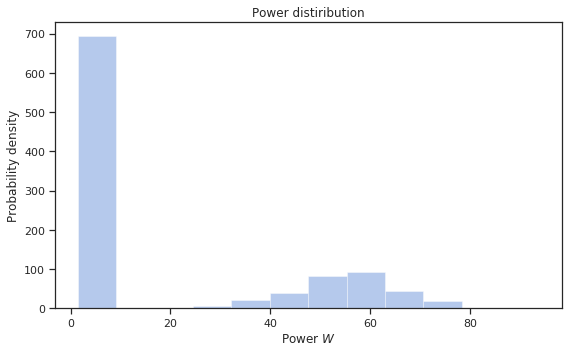

In [7]:
fig, ax =  plt.subplots(figsize=(8,5))
ax = sns.distplot(power, kde=False)
ax.set_xlabel("Power $W$")
ax.set_ylabel('Probability density')
ax.set_title("Power distiribution")
plt.tight_layout()

### Universality: Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow

In [8]:
def power_cost():
    state, power = tv_model()
    expected_power = 100. if state == 'ON' and power > 10.0 else 0.
    scale_power = 10. if state == 'ON' else 1.
    cost = pyro.sample('cost', pyro.distributions.Normal(expected_power, scale_power))
    return cost

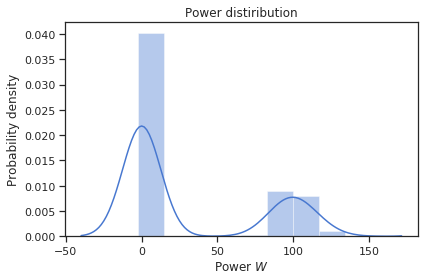

In [9]:
power = []
for _ in range(1000):
    power.append(power_cost().item())
ax = sns.distplot(power, kde=True)
ax.set_xlabel("Power $W$")
ax.set_ylabel('Probability density')
ax.set_title("Power distiribution")
plt.tight_layout()

In [10]:
def sleep_model():
    # Very likely to feel lazy
    feeling_lazy = pyro.sample("feeling_lazy", dist.Bernoulli(0.9))
    if feeling_lazy:
        # Only going to (possibly) ignore my alarm if I'm feeling lazy
        ignore_alarm = pyro.sample("ignore_alarm", dist.Bernoulli(0.8))
        # Will sleep more if I ignore my alarm
        amount_slept = pyro.sample("amount_slept",
                              dist.Normal(8 + 2 * ignore_alarm, 1))
    else:
        amount_slept = pyro.sample("amount_slept", dist.Normal(6, 1))
    return amount_slept

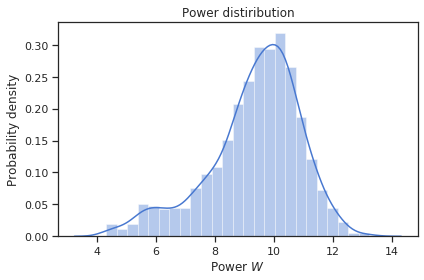

In [11]:
amount_slept = []
for _ in range(1000):
    amount_slept.append(sleep_model().item())
    #print(tv_model())
    
ax = sns.distplot(amount_slept, kde=True)
ax.set_xlabel("Power $W$")
ax.set_ylabel('Probability density')
ax.set_title("Power distiribution")
plt.tight_layout()

On the unconditional sleep model, we could ask a few questions, like:

- Joint probability of a sample: what is the probability that feeling_lazy = 1, ignore_alarm = 0, amount_slept = 10?
- Joint probability distribution: what is the probability for any possible assignment to all variables?
- Marginal probability of a sample: what is the probability that feeling_lazy is true?
- Marginal probability distribution: what is the probability over all values of amount_slept?

## Traces and conditioning

Poutine is a library of composable effect handlers for recording and modifying the behavior of Pyro programs. These lower-level ingredients simplify the implementation of new inference algorithms and behavior.

**Trace**: Return a handler that records the inputs and outputs of primitive calls and their dependencies.

We can record its execution using trace and use the resulting data structure to compute the log-joint probability of all of the sample sites in the execution or extract all parameters.

In [12]:
from pyro.poutine import trace
from pprint import pprint


tr = trace(sleep_model).get_trace()


pprint({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in tr.nodes.items()
    if props['type'] == 'sample'
})

{'amount_slept': {'prob': tensor(0.108), 'value': tensor(7.615)},
 'feeling_lazy': {'prob': tensor(0.100), 'value': tensor(0.)}}


In [13]:
print(tr.log_prob_sum().exp())

tensor(0.011)


Here, the trace feature will collect values every time they are sampled with sample and store them with the corresponding string name (that’s why we give each sample a name). With a little cleanup, we can print out the value and probability of each random variable’s value, along with the joint probability of the entire trace.

The code above randomly generates a trace and shows its probability, but we want to compute the probability of a pre-selected set of values. For that, we can use condition:

In [14]:
from pyro import condition

cond_model = condition(sleep_model, {
    "feeling_lazy": torch.tensor(1.),
    "ignore_alarm": torch.tensor(0.),
    "amount_slept": torch.tensor(10.)
})

trace(cond_model).get_trace().log_prob_sum().exp() 

tensor(0.010)

Here, condition means “force the sample to return the provided value, and compute the trace probability as if that value was sampled.

Inuitively, this particular choice should have low probability because if we didn’t ignore our alarm, then amount_slept should be closer to 8, not 10. That’s reflected in the low joint probability of 0.010.

Now, we can produce an approximate answer to any of our questions above by sampling from the distribution enough times. For example, we can look at the marginal distribution over each variable:

In [15]:
traces = []
for _ in range(1000):
    tr = trace(sleep_model).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

df = pd.DataFrame(traces)

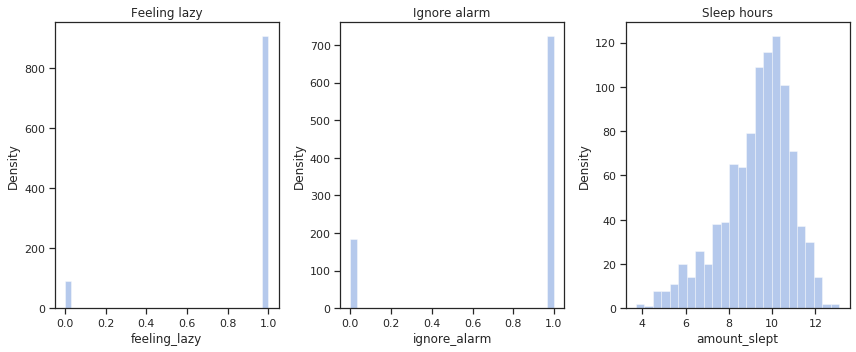

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
sns.distplot(df['feeling_lazy'], ax=axs[0], kde=False)
sns.distplot(df['ignore_alarm'], ax=axs[1], kde=False)
sns.distplot(df['amount_slept'], ax=axs[2], kde=False)
axs[0].set(ylabel="Density", title="Feeling lazy")
axs[1].set(ylabel="Density", title="Ignore alarm");
axs[2].set(ylabel="Density", title="Sleep hours");
plt.tight_layout()

Look at each histogram and see if its distribution matches your expectations given the code for sleep_model. For example, the feeling_lazy histogram is true (or 1) about 90% of the time, which matches the prior belief Bernoulli(0.9).

### Sampling conditional distributions
Here’s a few more questions we might want to answer.

- Given I slept 6 hours, what is the probability I was feeling lazy?
- What is the probability of me sleeping exactly 7.65 hours?

These are conditional probability questions, meaning they ask: given a particular value of some of the random variables, what are the likely values for the other random variables? 

A common use case for generative models is that the generated object is the thing you observe in the real world (like an image), and you want to guess the values of unobserved variables given that observation (like whether the image is a cat or a dog).

Considering the first question a smart watch can probably record my sleep patterns, but not record whether I was being lazy. So in the sleep model, we could say amount_slept is an observed random variable while feeling_lazy and ignore_alarm are latent random variables. Applying some basic probability theory, we can write out the quantity we want to compute:

\begin{align*}
P(\text{feeling lazy} = T \mid \text{amount slept} = 6) 
=&\frac{P(\text{feeling lazy} = T, \text{amount slept} = 6)}{P(\text{amount slept} = 6)} \\
=&\frac{\sum_{ia \in \{T, F\}} P(\text{feeling lazy} = T, \text{amount slept} = 6, \text{ignore alarm} = ia)}{\sum_{(ia, fl) \in \{T, F\}^2} P(\text{feeling lazy} = fl, \text{amount slept} = 6, \text{ignore alarm} = ia)}
\end{align*}

To create a basic importance sampler over execution traces (using the prior as the proposal distribution), we can write:

## Approximate inference

### Grid approximation
Let’s say I have an extremely simple model that just samples a normal distribution with fixed parameters:

In [23]:
def model():
    mu = pyro.param("mu", torch.tensor(0.))
    return pyro.sample("x", dist.Normal(mu, 1))

However, let’s say we know the value of x = 5 and I want to find a mean $\mu$ to the normal distribution that maximizes the probability of seeing that x

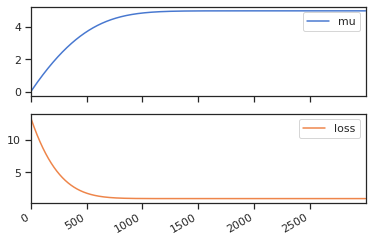

In [26]:
pyro.clear_param_store()
model() # Instantiate the mu parameter
cond_model = condition(model, {"x": 5})

# Large learning rate for demonstration purposes
optimizer = torch.optim.Adam([pyro.param("mu")], lr=0.01)
mus = []
losses = []
for _ in range(3000):
    tr = trace(cond_model).get_trace()

    # Optimizer wants to push positive values towards zero,
    # so use negative log probability
    prob = -tr.log_prob_sum()
    prob.backward()

    # Update parameters according to optimization strategy
    optimizer.step()

    # Zero all parameter gradients so they don't accumulate
    optimizer.zero_grad()

    # Record probability (or "loss") along with current mu
    losses.append(prob.item())
    mus.append(pyro.param("mu").item())

df=pd.DataFrame({"mu": mus, "loss": losses})
df.plot(subplots=True);

In [37]:
mu=df[df.loss==df.loss.min()]["mu"].values[-1]
dist.Normal(mu, 0).sample()

tensor(5.000)

We have implemented maximum likelihood learning, meaning we used optimization to find parameters that maximize the  probability of data under our model. 

However, our goal was specifically to estimate the posterior distribution over unobserved (latent) variables. For example, returning to the sleep_model, let’s say we want to know the distribution over feeling_lazy and ignore_alarm if amount_slept = 6.

let’s say we want to know the distribution over feeling_lazy and ignore_alarm if amount_slept = 6. Intuitively, although their prior likelihood is high, that amount of sleep is much more likely explained by not feeling lazy, so we would 

### Guide

The guide is a stochastic function that represents a probability distribution over the latent (unobserved) variables. For example, this is a valid guide:
Given I slept 6 hours, what is the probability I was feeling lazy?

In [44]:
def sleep_guide():
    pyro.sample("feeling_lazy", dist.Delta(torch.tensor(1.0)))
    pyro.sample("ignore_alarm", dist.Delta(torch.tensor(0.)))

In [49]:
#Traces are directed graphs whose nodes represent primitive calls or input/output, and whose edges represent conditional dependence relationships between those primitive calls. 

trace(sleep_guide).get_trace().nodes['feeling_lazy']['value']

tensor(1.)

In [50]:
# Condition model on observed data
underslept_model = condition(sleep_model, {"amount_slept": 6.})

In [62]:
def elbo(guide, cond_model):
    dist = 0.
    for fl in [0., 1.]:
        for ia in [0., 1.] if fl == 1. else [0.]:
            log_prob = lambda f: trace(condition(
                f, {"feeling_lazy": torch.tensor(fl), "ignore_alarm": torch.tensor(ia)})) \
                .get_trace().log_prob_sum()
            guide_prob = log_prob(guide)
            cond_model_prob = log_prob(cond_model)
            term = guide_prob.exp() * (cond_model_prob - guide_prob)
            if not torch.isnan(term):
                dist += term
    return dist



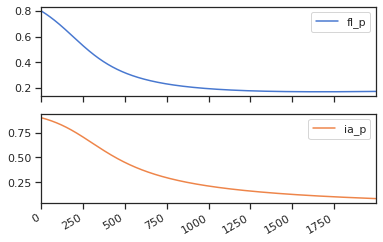

In [64]:
from torch.distributions import constraints
pyro.clear_param_store()

def sleep_guide():
    # Constraints ensure facts always remain true during optimization,
    # e.g. that the parameter of a Bernoulli is always between 0 and 1
    valid_prob = constraints.interval(0., 1.)
    fl_p = pyro.param('fl_p', torch.tensor(0.8), constraint=valid_prob)
    ia_p = pyro.param('ia_p', torch.tensor(0.9), constraint=valid_prob)
    feeling_lazy = pyro.sample('feeling_lazy', dist.Bernoulli(fl_p))

    # Consistent with the model, we only sample ignore_alarm if
    # feeling_lazy is true
    if feeling_lazy == 1.:
        pyro.sample('ignore_alarm', dist.Bernoulli(ia_p))
sleep_guide()

adam = torch.optim.Adam([pyro.param('fl_p').unconstrained(), pyro.param('ia_p').unconstrained()],
            lr=0.005, betas=(0.90, 0.999))
param_vals = []

for _ in range(2000):
    # We can use our elbo function from earlier and compute its gradient
    loss = -elbo(sleep_guide, underslept_model)
    loss.backward()

    adam.step()
    adam.zero_grad()

    param_vals.append({k: pyro.param(k).item() for k in ['fl_p', 'ia_p']})

df=pd.DataFrame(param_vals)
df.plot(subplots=True);

In [66]:
underslept_model()

6.0

### Example

Suppose you have a globe representing our planet, the Earth. This version of the world
is small enough to hold in your hands. You are curious how much of the surface is covered
in water. You adopt the following strategy: You will toss the globe up in the air. When you
catch it, you will record whether or not the surface under your right index finger is water or
land. Then you toss the globe up in the air again and repeat the procedure. This strategy
generates a sequence of surface samples from the globe.

$$WWLWLWLLWWWL$$

Let assume that:
1. The true proportion of water covering the globe is $p$
2. A single toss of the globe has a probability p of producing a water (W) observation. It has a probability $1 − p$ of producing a land (L) observation.
3. Each toss of the globe is independent of the others.

### Probabilistic model

#### Components
1. Observable varibales: the counts of water $N_W$ and land $N_L$ such that $N = N_W + N_L$
2. Non obervable variables (parameters):the proportion of water on the glob $p$
3. Likelihood: $p^{N_W}(1-p)^{N_L}$
4. Prior distribution which is the probability of paratemeter availabe beforehand, and before making any additional observations let assume uniform prior between 0 and 1.

Our model:

$$W \sim Binomial(N, p)$$

$$ p \sim Uniform(0,1)$$

The joint probability of the data W and L and any particular value of p is

$$P(W, L, p) = P(W, L|p)\cdot P(p)$$


The posterior probability:the probability of any particular value of p, consid-
ering the data

$$P(p|W,L) = \frac{P(W, L|p)\cdot P(p)}{P(W,L)}$$

Suppose we observe six water after 10 counts. What is the fraction of surfcae covered by water.

In [67]:
def model(w, n=9):
    p = pyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    pyro.sample("w", dist.Binomial(n, p), obs=w)  # binomial likelihood

In [68]:
trace(model).get_trace(torch.tensor(6.))
tr.log_prob_sum()

tensor(-2.584)

In [69]:
# find good initial trace
model_trace = trace(model).get_trace(torch.tensor(6.0))
best_log_prob = model_trace.log_prob_sum()
for i in range(10):
    trc = trace(model).get_trace(torch.tensor(6.0))
    log_prob = trc.log_prob_sum()
    if log_prob > best_log_prob:
        best_log_prob = log_prob
        model_trace = trc

In [73]:
model_trace = pyro.poutine.util.prune_subsample_sites(model_trace)
prior, unpacked = {}, {}
param_constraints = pyro.get_param_store().get_state()['constraints']
param_constraints

{'params': {}, 'constraints': {}}

In [ ]:
def grid_approximation(steps=20, W=6.0, N=10):
    # define grid
    p_grid = torch.linspace(start=0, end=1, steps=steps)

    # define prior
    pr = torch.tensor(1.).repeat(steps)

    # compute likelihood at each value in grid
    likelihood = dist.Binomial(total_count=N,
                               probs=p_grid).log_prob(torch.tensor(W)).exp()

    # compute product of likelihood and prior
    unstd_posterior = likelihood * pr

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return p_grid, posterior

In [ ]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(8,4))
for i, W in enumerate([2,5,8]):
    p_grid, posterior = grid_approximation(steps=20, W=float(W), N=10.)
    sns.lineplot(p_grid, posterior, marker="o", ax=axs[i])
    axs[i].set(xlabel="$p$", ylabel="posterior probability", title=f"{W} observation");

## 2.2 Representing Marginal Distributions
Before using our model to estimate  appliance power consumption let’s  analyzing our model’s behavior.Using importance sampling we can simulate the marginal distribution of measurement values we’d expect to see a priori for a given guess.

To do this using marginalization (**pyro.infer.impericalMarginal**) we need to follow the follwing two steps
- collect a number of weighted execution traces of the model through sampling using **Importance sampler**.
- collapse those traces into a histogram over possible return values given a particular set of arguments.

To create a basic importance sampler over execution traces (using the prior as the proposal distribution), we can write:

In [ ]:
posterior = pyro.infer.Importance(tv_model, num_samples=1000)

The output of posterior is computed with posterior.run, which runs inference for a single input value. To collapse those traces into a histogram

In [ ]:
mean_on_power = 50
marginal = pyro.infer.EmpiricalMarginal(posterior.run(mean_on_power))

In [ ]:
fig, ax =  plt.subplots()
ax.hist([marginal().item() for _ in range(1000)], range=(0, 80.0), bins=30, color="C0");
ax.set_xlabel("Power $W$")
ax.set_title('$P(measurement |guess)$')
ax.set_ylabel("Number")
#format_histogram(ax)

### 2.3 Conditioning Models on Data

With probabilistic programming is possible to condition generative models on observed data and infer the latent factors that might have produced that data. In Pyro, the expression of conditioning  model is  separated from its evaluation via inference. This  make it possible to write a model once and condition it on many different observations.

Suppose we want to sample from the marginal distribution of power given input guess = 60, but now we have observed that measurement is 78. 

Using  **pyro.condition** function we can constrain the values of sample statements. This is a higher-order function that takes a model and a dictionary of data and returns a new model that has the same input and output signatures but always uses the given values at observed sample statements:

In [ ]:
conditioned_monitor = pyro.condition(monitor, data={"measurement": 75})


Because it behaves just like an ordinary Python function, conditioning can be deferred or parametrized with Python’s lambda or def:

In [ ]:
def deferred_conditioned_monitor(measurement, *args, **kwargs):
    return pyro.condition(monitor, data={"measurement": measurement})(*args, **kwargs)


It also possible to pass observations directly to individual **pyro.sample** statements instead of using **pyro.condition**. The optional **obs** keyword argument is reserved by pyro.sample for that purpose:

```python
 pyro.sample("measurement", dist.Normal(power, 1.), obs=75)
```
However, hardcoding is not usually recommended due to its invasive non-compositional nature.

In addition to **pyro.condition** for incorporating observations, Pyro also contains **pyro.do**, that is used for causal inference with an identical interface to **pyro.condition**. These two function can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference.

We can use the conditioned model to estimate the distribution over power given guess and measurement == data as follows.

In [ ]:
guess = 65.
measurement = 75.

conditioned_scale = pyro.condition(monitor, data={"measurement": measurement})
marginal = pyro.infer.EmpiricalMarginal(pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="power")

fig, ax =  plt.subplots()
ax.hist([marginal().item() for _ in range(100)], range=(50, 70.0), bins=30, color="C0");
ax.set_xlabel("Power $W$")
ax.set_title('$P(measurement |guess)$')
ax.set_ylabel("Number")
format_histogram(ax)


However, this approach is extremely computationally inefficient because the prior distribution over power may be very far from the true distribution over power, especially if our initial guess is not very good.

## 2.4 Guide function

Some inference algorithms in Pyro, like **pyro.infer.Importance** and **pyro.infer.SVI**, allow us to use arbitrary stochastic functions, which we will call guide functions or **guides**, as approximate posterior distributions. 

Guide functions have to satisfy the following two criteria to be valid approximations for a particular model: 
1. all unobserved sample statements that appear in the model appear in the guide. 
2. the guide has the same input signature as the model (i.e. takes the same arguments)

Guide functions can serve as programmable, data-dependent proposal distributions for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference. 

The current pyro version only implement importance sampling and stochastic variational inference. More algorithms will be addded in the future.

In [ ]:
def monitor_posterior_guide(measurement, guess):

    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("power", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_monitor,
                                  guide=monitor_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="power")
fig, ax =  plt.subplots()
ax.hist([marginal().item() for _ in range(100)], range=(50, 70.0), bins=30, color="C0");
ax.set_xlabel("Power $W$")
ax.set_title('$P(measurement |guess)$')
ax.set_ylabel("Number")
format_histogram(ax)

## Parametrized Stochastic Functions and Variational Inference

It is intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function. What we can do instead is use the top-level function **pyro.param** to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation. This approach to approximate posterior inference is called **variational inference**.

 Like pyro.sample, pyro.param is always called with a name as its first argument. For example, we can parametrize a and b in monitor_posterior_guide instead of specifying them by hand:

In [ ]:
def monitor_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("power", dist.Normal(a, torch.abs(b)))


Pyro is built to enable stochastic variational inference, a powerful and widely applicable class of variational inference algorithms with three key characteristics:

1. Parameters are always real-valued tensors
2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide
3. We use stochastic gradient descent to search for the optimal parameters.


In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_monitor,
                     guide=monitor_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))


In [ ]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");


The optimization will update the guide parameters, but does not produce a posterior distribution object itself. Once we find good parameter values, we can just use the guide as a representation of the model’s approximate posterior for downstream tasks.

For example, we can use the optimized guide as an importance distribution for estimating the marginal distribution over power with many fewer samples than the prior:

In [ ]:
posterior = pyro.infer.Importance(conditioned_monitor, monitor_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="power")
fig, ax =  plt.subplots()
ax.hist([marginal().item() for _ in range(100)], range=(60, 70.0), bins=30, color="C0");
ax.set_xlabel("Power $W$")
ax.set_title('$P(measurement |guess)$')
ax.set_ylabel("Number")
format_histogram(ax)

In [ ]:
fig, ax =  plt.subplots()
ax.hist([monitor_parametrized_guide(guess).item() for _ in range(100)], range=(60.0, 80.0), bins=30, color="C0");
ax.set_xlabel("Power $W$")
ax.set_title('$P(measurement |guess)$')
ax.set_ylabel("Number")
format_histogram(ax)


### SMS

In [ ]:
figsize(12.5, 3.5)
count_data = np.loadtxt("../data/sms.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [ ]:
alpha_f = 1.0 / count_data.mean()
alpha = torch.tensor(alpha_f)

In [ ]:
def intensity_function(i, switch_point, mu1, mu2, sigma1, sigma2):
    sigmoid = torch.sigmoid(float(i) - switch_point)
    mu = (1.0 - sigmoid) * mu1 + mu2 * sigmoid                
    sigma = (1.0 - sigmoid) * sigma1 + sigma2 * sigmoid
    return mu, sigma

In [ ]:
def model():
    mu1 = pyro.sample("mu1", dist.Exponential(alpha))
    sigma1 = pyro.sample("sigma1", dist.Exponential(torch.tensor(0.1)))
    mu2 = pyro.sample("mu2", dist.Exponential(alpha))
    sigma2 = pyro.sample("sigma2", dist.Exponential(torch.tensor(0.1)))

    switch_point = pyro.sample("switch_point", dist.Beta(torch.tensor(10.), torch.tensor(10.))) * torch.tensor(float(len(count_data)))
    
    for i in range(len(count_data)):
        mu_i, sigma_i = intensity_function(i, switch_point, mu1, mu2, sigma1, sigma2)
        pyro.sample("obs_{}".format(i), dist.Normal(mu_i, sigma_i), obs=torch.tensor(count_data[i])) 
        
        
def guide(count_data):
   
    switch_probs = pyro.param("switch_probs", torch.ones(1 + len(count_data)) / (1 + len(count_data)),
                              constraint=constraints.simplex)
    pyro.sample("switch_point", dist.Categorical(switch_probs),
                infer={'enumerate': 'parallel'})

In [93]:
data = torch.cat((torch.zeros(9), torch.ones(7), torch.empty(4).fill_(2.)))
data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
        2., 2.])

In [89]:
def model():
    alpha = torch.tensor(6.0)
    beta = torch.tensor(10.0)
    pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta))
    return pay_probs

In [90]:
normalized_pay_probs

tensor(1.)

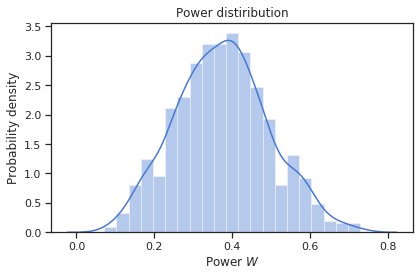

In [91]:
amount_slept = []
for _ in range(1000):
    amount_slept.append(model().item())
    #print(tv_model())
    
ax = sns.distplot(amount_slept, kde=True)
ax.set_xlabel("Power $W$")
ax.set_ylabel('Probability density')
ax.set_title("Power distiribution")
plt.tight_layout()